In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import scipy.stats as ss

import numpy as np

from tqdm.notebook import trange

import matplotlib.pyplot as plt

# Data Generating Process

fix parameters 

In [144]:
def bootstrap(x,size):
    indices = np.random.choice(np.arange(len(x)),size)
    return x[indices]

In [27]:
DIM = 1
OFFSET= 2
NUM_UNLABELED = 10000
NUM_LABELED = 1000
COV = 1
ZCOV= np.eye(DIM)

# UNLABELED
pi = .5
mu_1,mu_2 = np.zeros(DIM) + OFFSET, np.zeros(DIM) - OFFSET
y = np.random.binomial(1,pi,size=NUM_UNLABELED).astype(bool)
z = np.zeros((NUM_UNLABELED,DIM))
z[y] = np.random.multivariate_normal(mu_1,ZCOV,size=y.sum())
z[~y] = np.random.multivariate_normal(mu_2,ZCOV,size=y.shape[0] - y.sum())
x = torch.normal(torch.Tensor(z),COV)
# POSITIVE
zp = np.random.multivariate_normal(mu_1,np.eye(DIM),size=NUM_LABELED)
xp = bootstrap(torch.normal(torch.Tensor(zp),1),NUM_UNLABELED)

(array([0.00737262, 0.00737262, 0.02484845, 0.04450876, 0.04314347,
        0.10731253, 0.12588061, 0.13134181, 0.18622683, 0.25967998,
        0.29545073, 0.27196767, 0.28616679, 0.23373928, 0.20834471,
        0.11222755, 0.13680302, 0.09092901, 0.06771877, 0.04996996,
        0.01829501, 0.0150183 , 0.        , 0.00245754, 0.00382284]),
 array([-2.2776542 , -1.9114342 , -1.545214  , -1.178994  , -0.812774  ,
        -0.446554  , -0.08033396,  0.28588608,  0.6521061 ,  1.0183262 ,
         1.3845462 ,  1.7507663 ,  2.1169863 ,  2.4832063 ,  2.8494263 ,
         3.2156463 ,  3.5818665 ,  3.9480865 ,  4.3143063 ,  4.6805267 ,
         5.0467467 ,  5.4129667 ,  5.7791867 ,  6.1454067 ,  6.5116267 ,
         6.8778467 ], dtype=float32),
 <a list of 25 Patch objects>)

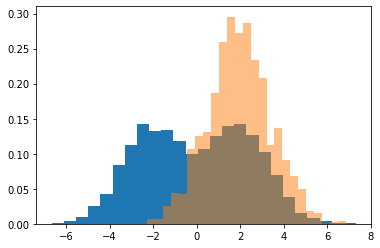

In [28]:
plt.hist(x.ravel(),bins=25,density=True)
plt.hist(xp.ravel(),bins=25,density=True,alpha=.5)
# plt.hist(x[~y].ravel(),bins=25,alpha=.5)

In [148]:
class PUVAE(pl.LightningModule):
    def __init__(self,input_dim, h_dim, z_dim,COV,ZCOV,EMSTEPS=10,JOINT_EM=True):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, h_dim),nn.ReLU(),
                                     nn.Linear(h_dim, h_dim),nn.ReLU(),
                                     nn.Linear(h_dim, h_dim),nn.ReLU())
        self.mu_encoder = nn.Sequential(nn.Linear(h_dim, z_dim))
        self.cov_encoder = nn.Sequential(nn.Linear(h_dim, z_dim))
        self.decoder = nn.Sequential(nn.Linear(z_dim, h_dim), nn.ReLU(),
                                     nn.Linear(h_dim, h_dim), nn.ReLU(),
                                     nn.Linear(h_dim, input_dim))
        self.pi = torch.ones(1) * .5
        self.mu = torch.eye(z_dim) 
        self.z_dim = z_dim
        self.EMSTEPS = EMSTEPS
        self.COV = COV
        self.ZCOV = ZCOV
        self.JOINT_EM= JOINT_EM
        
    def forward(self, x):
        N = x.shape[0]
        epsilon = self.encoder(x)
        z_1 = z_1_2[...,:self.z_dim] + torch.normal(torch.zeros((N,self.z_dim)),1)
        z_2 = z_1_2[...,self.z_dim:] + torch.normal(torch.zeros((N,self.z_dim)),1)
        z = self.pi * z_1 + (1 - self.pi) * z_2
        return z

    def training_step(self, batch, batch_idx):
        # separate positive and unlabeled
        xP, x = batch
        ############## UNSUPERVISED STEPS #########
        N = x.shape[0]
        ######### Sample from q(z|x) ############
        h = self.encoder(x)
        mu = self.mu_encoder(h)
        sigma = torch.exp(self.cov_encoder(h))
        eps = torch.randn(*mu.shape)
        z = eps * sigma + mu
        ######### Sample from q(z|xp) ##########
        hP = self.encoder(xP)
        muP = self.mu_encoder(hP)
        sigmaP = torch.exp(self.cov_encoder(hP))
        epsP = torch.randn(*muP.shape)
        zP = epsP * sigmaP + muP
        ####### Calculate q(z|x) ###############
        n = torch.distributions.Normal(mu,sigma)
        qzx = n.log_prob(z).sum(-1)
        ####### Calculate q(zP|xP) ###############
        nP = torch.distributions.Normal(muP,sigma)
        qzPxP = nP.log_prob(zP).sum(-1)
        ###### Calculate p(x|z) ###############
        xHat = self.decoder(z)
        n1 = torch.distributions.Normal(xHat, self.COV)
        pxz = n1.log_prob(xHat).sum(-1)
        ###### Calculate p(xP|zP) ###############
        xPHat = self.decoder(zP)
        n1P = torch.distributions.Normal(xPHat, self.COV)
        pxPzP = n1.log_prob(xPHat).sum(-1)
        ########## EM-Steps ###################
        # two options either include labeled data (and fix gammas) or exclude as is done below
        delta = 1
        if self.JOINT_EM:
            zd = torch.concat([z, zP]).detach()
        else:
            zd = z.detach()
        for em_step in range(self.EMSTEPS):
            #################### E-STEP #######################################
            m0 = torch.distributions.Normal(self.mu[0],self.ZCOV)
            m1 = torch.distributions.Normal(self.mu[1],self.ZCOV)
            gamma_0 = (torch.log((1-self.pi)) + m0.log_prob(zd)).sum(-1)
            gamma_1 = (torch.log(self.pi) + m1.log_prob(zd)).sum(-1)
            gamma_0_1 = torch.softmax(torch.stack([gamma_0,gamma_1]),0)
            gamma_n_0 = gamma_0_1[0]
            gamma_n_1 = gamma_0_1[1]
            if self.JOINT_EM:
                gamma_n_0[-zP.shape[0]:] = 0
                gamma_n_1[-zP.shape[0]:] = 1
            ################### M-STEP #########################################
            n0 = gamma_n_0.sum()
            n1 = gamma_n_1.sum()
            self.mu[0] = (gamma_n_0[...,None] * zd).sum(0) / (n0 + delta)
            self.mu[1] = (gamma_n_1[...,None] * zd).sum(0) / (n1 + delta)
            self.pi = n1 / (n0 + n1)
#         print(self.mu)
        print(self.pi)
        ########### Calculate p(z) ###########################################
        p0 = torch.distributions.Normal(self.mu[0],self.ZCOV)
        p1 = torch.distributions.Normal(self.mu[1],self.ZCOV)
        pz = torch.logsumexp(torch.stack([(torch.log(self.pi) + p1.log_prob(z)).sum(-1),
                                          (torch.log(1 - self.pi) + p0.log_prob(z)).sum(-1)]),0)
        ############ Calculate p(zP) #######################################
        pzP = (torch.log(self.pi) + p1.log_prob(zP)).sum(-1)
        ############ Calculate ELBO-U #########################################
        elboU = (pxz + pz - qzx).mean()
        ############## Calculate ELBO-P ###########################
        elboP = (pxPzP + pzP - qzPxP).mean()
        loss = -(elboU + elboP)
        ############### Total Loss ############

        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [149]:
puvae = PUVAE(DIM,32,2,COV=COV,ZCOV=torch.Tensor(ZCOV),EMSTEPS=100,JOINT_EM=True)

In [150]:
dl = DataLoader(TensorDataset(xp, x),batch_size=128)

In [151]:
trainer = pl.Trainer(max_epochs=100, )
trainer.fit(puvae, dl)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 2.2 K 
1 | mu_encoder  | Sequential | 66    
2 | cov_encoder | Sequential | 66    
3 | decoder     | Sequential | 1.2 K 
-------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)

In [117]:
puvae.mu

tensor([[ 0.3041, -0.1140],
        [ 0.0000,  1.0000]])

In [57]:
puvae.pi, puvae.mu

(tensor(nan, dtype=torch.float64),
 tensor([[nan, nan],
         [nan, nan]]))

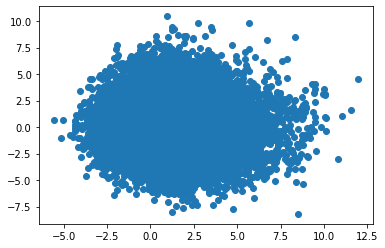

In [265]:
plt.scatter(* puvae(inputs).T.detach())